In [125]:
%matplotlib inline
%run ../skeleton.py
%run ../animation.py

In [13]:
skeleton = load_skeleton(r'../skeleton.dat')
animations = [load_animation("anim_{}.dat".format(i)) for i in range(3)]

In [76]:
import k3d

def plot_skeleton(plot, skeleton):
    for i in range(len(skeleton._bones)):
        if skeleton._bones[i]._parentId >= 0:
            startM = skeleton.globalMatrix(i)
            endM = skeleton.globalMatrix(skeleton._bones[i]._parentId)
            p = k3d.line([startM[3][:3], endM[3][:3]], width=0.05, color=0x2233FF)
            p.model_matrix = np.array([[1,0,0,0],[0,0,-1,0],[0,1,0,0],[0,0,0,1]])
            plot += p

def plot_animation(plot, skeleton, animation):
    #plot skeleton at 2 frames
    keycount, tracks = animation
    skeleton.load_animation(animation, int(keycount/2) )
    plot_skeleton(plot, skeleton)

    
    #plot trajectories
    boneIds = [skeleton.bone_id(n) for n in ['Hips','LeftHand','RightHand','LeftFoot','RightFoot']]
    lines = [[] for i in range(len(boneIds))]
    for frame in range(keycount):
        skeleton.load_animation(animation, frame )
        for i,boneId in enumerate(boneIds):
            lines[i].append(skeleton.globalMatrix(boneId)[3][:3])
            
    for i in range(len(boneIds)):
        p = k3d.line(lines[i], shader='simple', color=0xFF22FF)
        p.model_matrix = np.array([[1,0,0,0],[0,0,-1,0],[0,1,0,0],[0,0,0,1]])
        plot += p
        
        
def plot_anchor(plot, skeleton):
    p = k3d.points([
            skeleton.anchorGlobalPosition(i) for i in range(len(skeleton._anchors))
        ], point_size=0.02, color=0x55FF00)
    p.model_matrix = np.array([[1,0,0,0],[0,0,-1,0],[0,1,0,0],[0,0,0,1]])
    plot += p
        
    
        
plot = k3d.plot()
plot_animation(plot, skeleton, animations[0])   
plot.display()

44


Output()

In [74]:
plot = k3d.plot()  
skeleton = load_skeleton(r'../skeleton.dat')
plot_skeleton(plot,skeleton)
plot_anchor(plot,skeleton)
plot.display()

Output()

In [77]:
plot = k3d.plot()
plot_animation(plot, skeleton, animations[0])   
plot_animation(plot, skeleton, animations[1])
plot.display()

44
69


Output()

In [33]:
from scipy.optimize import minimize

def point_cloud(skeleton):
    cloud = np.array([skeleton.anchorGlobalPosition(i) for i in range(len(skeleton._anchors))])
    average = np.average(cloud, axis=0)
    average[1] = 0
    return cloud - average

def rotate_cloud(cloud, theta):
    c, s = np.cos(theta), np.sin(theta)
    M = np.array([[c,0,s],[0,1,0],[-s,0,c]])
    return cloud.dot(M)

def align_cloud(cloud, x,z,t):
    cloud = rotate_cloud(cloud, t)
    return cloud + np.array([x,0,z])

skeleton.load_animation(animations[0], 10 )
cloud_a = point_cloud(skeleton)

skeleton.load_animation(animations[1], 35 )
cloud_b = point_cloud(skeleton)

plot = k3d.plot()
p = k3d.points(cloud_a, point_size=0.02, color=0x55FF00)
p.model_matrix = np.array([[1,0,0,0],[0,0,-1,0],[0,1,0,0],[0,0,0,1]])
plot += p

p = k3d.points(cloud_b, point_size=0.02, color=0xFF5500)
p.model_matrix = np.array([[1,0,0,0],[0,0,-1,0],[0,1,0,0],[0,0,0,1]])
plot += p

plot.display()

def _objective(xzt):
    x,z,t = xzt
    cloud = align_cloud(cloud_b, x,z,t)
    v = cloud_a - cloud
    return np.sum(v*v) * 0.5

sol = minimize(_objective, [0,0,0], method='SLSQP')
print (sol)

p = k3d.points(align(cloud_b,*sol.x), point_size=0.02, color=0x0000FF)
p.model_matrix = np.array([[1,0,0,0],[0,0,-1,0],[0,1,0,0],[0,0,0,1]])
plot += p

print (_objective([0,0,0]))
print (_objective(sol.x))

NameError: name 'k3d' is not defined

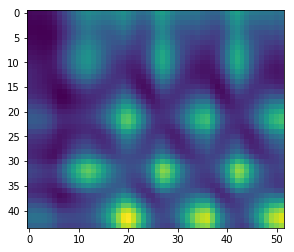

In [46]:
def compute_errors_between_2_animations(anim_a, anim_b, skeleton):
    keycount_a, _ = anim_a
    anim_a_clouds = []
    for frame in range(keycount_a):
        skeleton.load_animation(anim_a, frame)
        anim_a_clouds.append(point_cloud(skeleton))
        
    keycount_b, _ = anim_b
    anim_b_clouds = []
    for frame in range(keycount_b):
        skeleton.load_animation(anim_b, frame)
        anim_b_clouds.append(point_cloud(skeleton))
        
    def _objective(xzt, cloud_a, cloud_b):
        x,z,t = xzt
        cloud = align_cloud(cloud_b, x,z,t)
        v = cloud_a - cloud
        return np.sum(v*v) * 0.5
    
    errors = []
    for frame_a in range(keycount_a):
        errors.append([])
        for frame_b in range(keycount_b):
            extra = (anim_a_clouds[frame_a], anim_b_clouds[frame_b])
            sol = minimize(_objective, [0,0,0], method='SLSQP', args=extra)
            errors[frame_a].append(sol.fun)
        
    return np.array(errors)

errors = compute_errors_between_2_animations(animations[0], animations[2], skeleton)
import matplotlib.pyplot as plt
plt.imshow( errors )

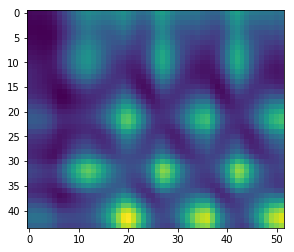